### Постановка задачи

**Задача**  

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

* `course_project_train.csv` - обучающий датасет
* `course_project_test.csv` - тестовый датасет

**Целевая переменная**

* `Credit Default` - факт невыполнения кредитных обязательств

**Метрика качества**

* `F1-score` (sklearn.metrics.f1_score)

**Требования к решению**

* Целевая метрика F1 > 0.5

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Решение должно содержать**

* Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу `{ФИО}_solution.ipynb`, пример `SShirkin_solution.ipynb`
* Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу `{ФИО}_predictions.csv`, пример `SShirkin_predictions.csv`
* Рекомендации для файла с кодом (ipynb)
* Файл должен содержать заголовки и комментарии (markdown)
* Повторяющиеся операции лучше оформлять в виде функций
* Не делать вывод большого количества строк таблиц (5-10 достаточно)
* По возможности добавлять графики, описывающие данные (около 3-5)
* Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
* Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
* Весь проект должен быть в одном скрипте (файл ipynb).
* Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.


**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**

1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Подключение библиотек и загрузка данных

In [475]:
!pip install xgboost, lightgbm, catboost

ERROR: Invalid requirement: 'xgboost,'


In [476]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# rcParams['figure.figsize'] = 10, 8
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100

In [477]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [478]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [479]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [480]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (9, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [481]:
TRAIN_DATASET_PATH='course_project_train.csv'
TEST_DATASET_PATH='course_project_test.csv'
PREPARED_TRAIN_DATASET_PATH='train_prepared.csv'
PREPARED_TEST_DATASET_PATH='test_prepared.csv'

In [482]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)
* Credit Score - Кредитный балл

In [483]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [484]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [485]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Обзор данных

**Обзор целевой переменной**

In [486]:
target_values = df_train['Credit Default'].value_counts()
target_values

0    5387
1    2113
Name: Credit Default, dtype: int64

В целевой переменной дисбаланса нет

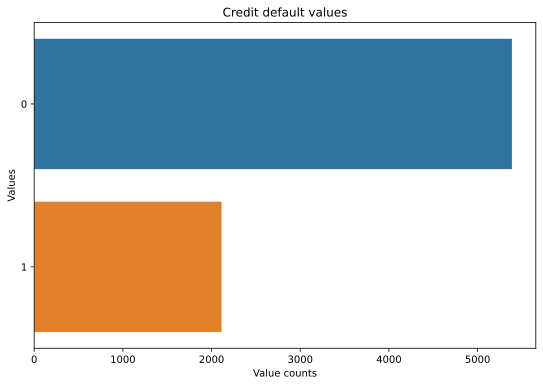

In [487]:
plt.figure(figsize=(9, 6))

sns.barplot(target_values.values, target_values.index, orient='h')
plt.title('Credit default values')
plt.xlabel('Value counts')
plt.ylabel('Values')
plt.show()

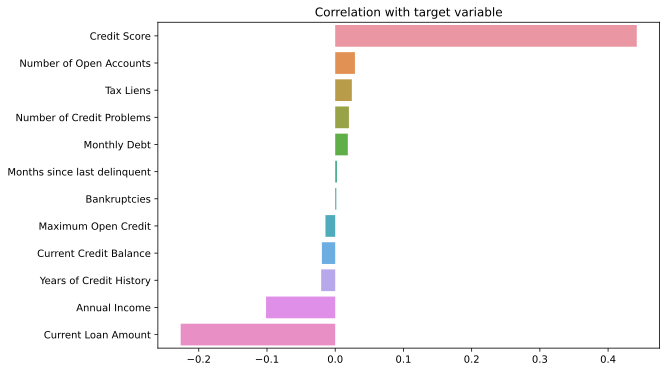

In [488]:
#Корелляция с базовыми признаками

TARGET = 'Credit Default'
FEATURES = df_train.columns.drop(TARGET).tolist()

corr_with_target = df_train[FEATURES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(9, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Обзор количественных признаков**

In [489]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


* `Annual Income` - есть пропущенные значения / связано с Years in current job
* `Tax Liens` значения по большей части - нули. Можно попробовать все ненулевые сделать 1
* `Number of Open Accounts` - есть выбросы (> 25)
* `Years of Credit History` - есть очень большие значения, пока оставим
* `Maximum Open Credit` - есть нулевые значения, они противоречат значениям текущей задолженности
* `Current Loan Amount` - значения более-манее нормальные
* `Current Credit Balance` 
* `Monthly Debt`
* `Number of Credit Problems`
* `Months since last delinquent` - есть пропущенные значения. Скорее всего связано с целевой переменной
* `Bankruptcies` - есть немного пропусков
* `Current Loan Amount` - значения более-манее нормальные
* `Credit Score` - есть много пропусков

In [490]:
credit = df_train['Maximum Open Credit']

df_train[credit == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,Home Mortgage,NaN,8 years,0.0,10.0,13.0,0.0,0.0,NaN,0.0,debt consolidation,Long Term,672078.0,19.0,8860.0,NaN,0
6851,Home Mortgage,2251728.0,10+ years,0.0,8.0,15.4,0.0,0.0,NaN,0.0,home improvements,Long Term,760452.0,0.0,36778.0,725.0,0
7014,Home Mortgage,1223771.0,5 years,0.0,9.0,24.0,0.0,0.0,NaN,0.0,small business,Long Term,751454.0,0.0,15348.0,737.0,1
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


In [491]:
df_train['Tax Liens'].value_counts().sort_values()

7.0       1
5.0       2
6.0       2
4.0       6
3.0      10
2.0      30
1.0      83
0.0    7366
Name: Tax Liens, dtype: int64

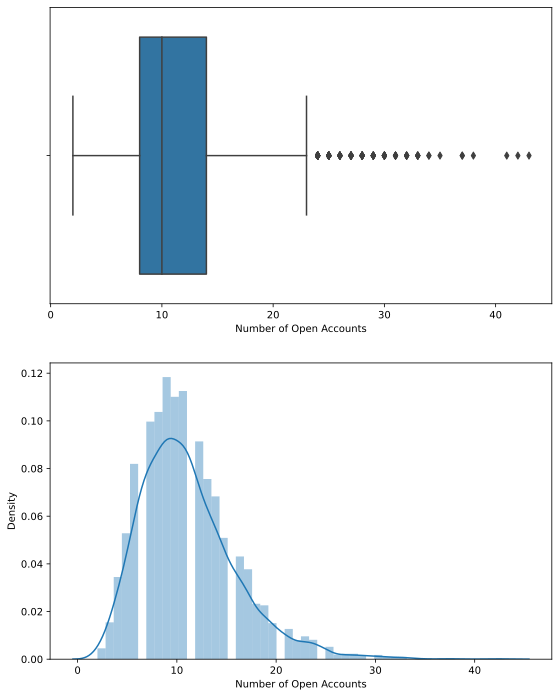

In [492]:
plt.figure(figsize=(9, 12))
plt.title('Number of Open Accounts distribution')

plt.subplot(211)
sns.boxplot(df_train['Number of Open Accounts'])
plt.xlabel('Number of Open Accounts')

plt.subplot(212)
sns.distplot(df_train['Number of Open Accounts'])
plt.xlabel('Number of Open Accounts')
plt.show()

In [493]:
df_train.loc[df_train['Years of Credit History'] > 36]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
80,Rent,NaN,10+ years,0.0,6.0,36.8,263934.0,0.0,70.0,0.0,debt consolidation,Long Term,111848.0,60173.0,16918.0,NaN,0
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,0.0,NaN,educational expenses,Short Term,99999999.0,224770.0,4326.0,734.0,0
179,Home Mortgage,1094837.0,NaN,0.0,9.0,39.3,611754.0,0.0,NaN,0.0,debt consolidation,Short Term,134420.0,230356.0,17700.0,743.0,0
206,Home Mortgage,1304407.0,2 years,0.0,12.0,40.3,607684.0,0.0,NaN,0.0,debt consolidation,Short Term,124652.0,455544.0,25979.0,747.0,1
226,Home Mortgage,509599.0,NaN,0.0,12.0,38.7,836220.0,0.0,NaN,0.0,other,Short Term,128744.0,578474.0,14354.0,704.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,Home Mortgage,1687542.0,NaN,0.0,10.0,42.0,253770.0,1.0,NaN,1.0,debt consolidation,Short Term,224598.0,188480.0,16172.0,734.0,0
7187,Rent,1727100.0,< 1 year,0.0,12.0,40.5,453222.0,0.0,40.0,0.0,debt consolidation,Short Term,99999999.0,167523.0,26482.0,728.0,0
7251,Home Mortgage,NaN,10+ years,0.0,8.0,51.0,1769900.0,0.0,27.0,0.0,debt consolidation,Long Term,439252.0,1369577.0,22516.0,NaN,1
7342,Home Mortgage,1343509.0,NaN,0.0,16.0,36.4,1308076.0,0.0,NaN,0.0,debt consolidation,Short Term,466686.0,512886.0,21944.0,750.0,0


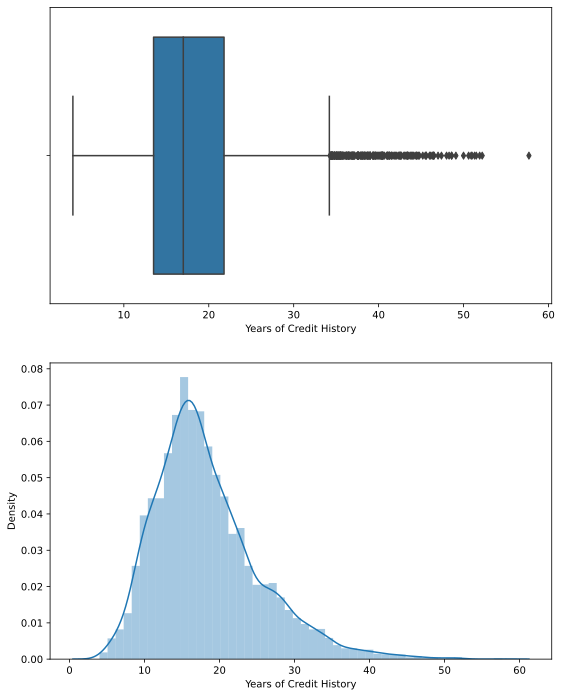

In [494]:
plt.figure(figsize=(9, 12))
plt.title('Number of Years of Credit History')

plt.subplot(211)
sns.boxplot(df_train['Years of Credit History'])
plt.xlabel('Years of Credit History')

plt.subplot(212)
sns.distplot(df_train['Years of Credit History'])
plt.xlabel('Years of Credit History')
plt.show()

In [495]:
df_train.loc[df_train['Maximum Open Credit'] > 9.451537e+06]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
354,Home Mortgage,2126537.0,10+ years,0.0,23.0,23.0,1.476048e+07,0.0,NaN,0.0,debt consolidation,Long Term,778624.0,1019806.0,40227.0,697.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
1476,Own Home,NaN,8 years,0.0,14.0,28.9,1.042866e+07,0.0,NaN,0.0,debt consolidation,Short Term,656766.0,1089802.0,16531.0,NaN,0
1879,Home Mortgage,1433835.0,6 years,0.0,8.0,17.8,1.270144e+07,0.0,35.0,0.0,debt consolidation,Short Term,197384.0,1985462.0,14099.0,749.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2468,Home Mortgage,5589420.0,4 years,0.0,11.0,12.3,1.634591e+07,0.0,24.0,0.0,home improvements,Long Term,99999999.0,2315169.0,74991.0,735.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0
3170,Home Mortgage,2226230.0,10+ years,0.0,20.0,19.0,1.868381e+07,0.0,NaN,0.0,buy a car,Short Term,111892.0,2355867.0,17123.0,750.0,0


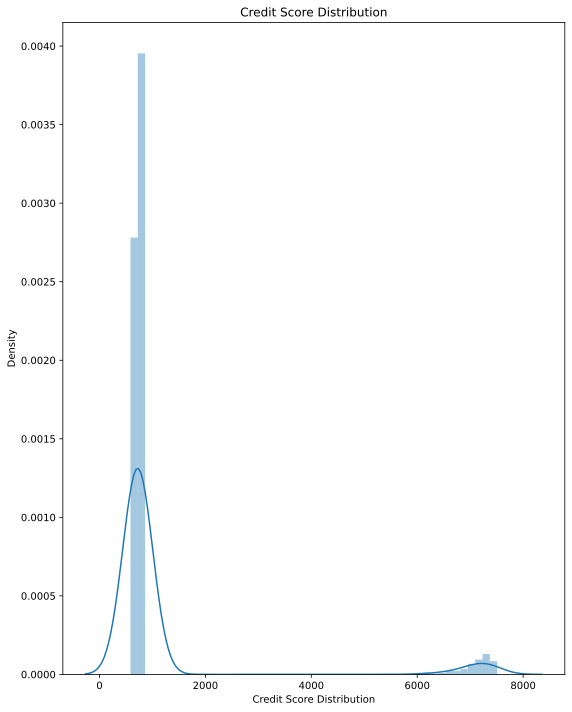

In [496]:
credit_score = df_train['Credit Score'].loc[df_train['Credit Score'] < 1000].sort_values()

plt.figure(figsize=(9, 12))
plt.title('Credit Score Distribution')
sns.distplot(df_train['Credit Score'])
plt.xlabel('Credit Score Distribution')
plt.show()

Видно, что есть значения, которые находятся в другом интервале значений. Посмотрим на значения в разрезе целевой переменной.

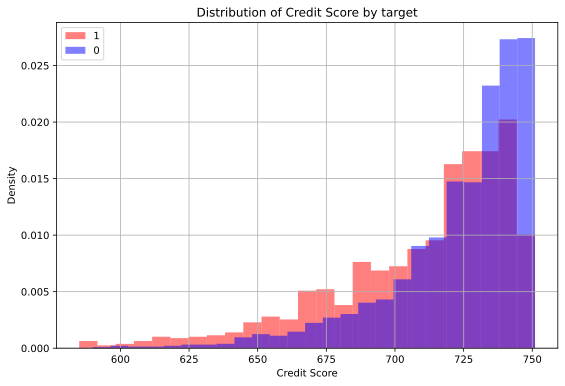

1184 1 values
4359 0 values


In [497]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) &
             (df_train['Credit Score'] < 1000), 
             'Credit Score'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) &
             (df_train['Credit Score'] < 1000), 'Credit Score'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Distribution of Credit Score by target')
plt.legend()
plt.show()

print("%d 1 values\n%d 0 values" % 
      (df_train.loc[(df_train['Credit Default'] == 1) & 
                    (df_train['Credit Score'] < 1000), 'Credit Score'].count(), 
                                   
       df_train.loc[(df_train['Credit Default'] == 0) & 
                    (df_train['Credit Score'] < 1000), 'Credit Score'].count()))
    


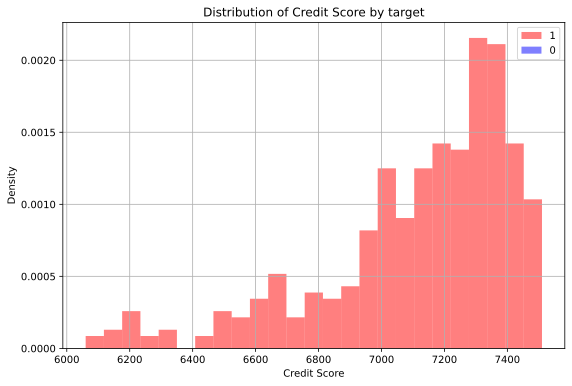

400 values


In [498]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) &
             (df_train['Credit Score'] > 1000), 
             'Credit Score'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) &
             (df_train['Credit Score'] > 1000), 'Credit Score'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Distribution of Credit Score by target')
plt.legend()
plt.show()

print (df_train.loc[(df_train['Credit Default'] == 1) & 
                    (df_train['Credit Score'] > 1000), 'Credit Score'].count(), 'values')


In [499]:
df_train.loc[(df_train['Credit Default'] == 1) &
             (df_train['Credit Score'] < 1000), 'Credit Score'].count()

1184

Все эти значения являются событием 1 целевой переменной, то есть целевое событие, и их доля довольно большая (400 наблюдений, против 1184 в другом интервале), по-этому эти значения оставим как есть.

**Обзор номинативных признаков**

In [500]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [501]:
df_train['Years in current job'].isnull().sum()

371

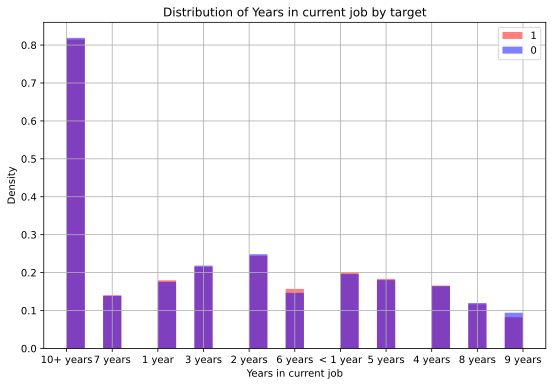

In [502]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1), 
             'Years in current job'].hist(bins=25, color ='r', density=True, alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0), 
             'Years in current job'].hist(bins=25, color ='b', density=True, alpha=0.5, label ='0')
plt.xlabel('Years in current job')
plt.ylabel('Density')
plt.title('Distribution of Years in current job by target')
plt.legend()
plt.show()

* `Home ownership` - Есть значение Have Mortgage, в котором всего 12 наблюдений (выбросы) и оно очень похоже на Home Mortgage, которое является самым часто встречающимся в датасете. заменим эти значения на mode()
* `Years in current job` - выбросов нет, больше всего значений 10+, пока неясна связь с целевой переменной 
* `Purpose` - значения vacation (8) и renewable energy (2) - выбросы, 2 заменим на самое популярное, а 8 заменим на Take a trip (это одно и то же)
* `Term` - здесь значения нормально распределены, выбросов нет

### Обработка пропусков 

* `Years in current job`
* `Months since last delinquent`
* `Bankruptcies`



Для обработки данных объединим датасета

In [503]:
df = pd.concat([df_train, df_test], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 7930 non-null   float64
 2   Years in current job          9543 non-null   object 
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  4561 non-null   float64
 9   Bankruptcies                  9983 non-null   float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

* `Years in current job` - Заменим на самое популярное значение

In [504]:
mode = df_train['Years in current job'].mode()[0]
df['Years in current job'].loc[df['Years in current job'].isnull()] = mode

* `Months since last delinquent` - скорее всего это отсутствие просрочек, то есть 0, заменим Nan на 0

In [505]:
df['Months since last delinquent'].fillna(0, inplace=True)

* `Bankruptcies` - скорее всего пропуски это тоже нули, это самое популярное значение 

In [506]:
df['Bankruptcies'].fillna(0, inplace=True)

### Обработка выбросов

* `Home Ownership`  - тип `Have Mortage` скорее всего то же самое, что и `Home Mortage`, объединим их

Home Mortgage    3637  
Rent             3204  
Own Home          647  
Have Mortgage      12  

In [507]:
df['Home Ownership'].loc[df['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'

* `Number of Open Accounts` - есть выбросы (больше 25 аккаунтов)

In [508]:
# df_train = df_train[df_train['Number of Open Accounts'] < 25]

* `Annual Income` - есть небольшое количество наблюдений, которые выбиваются из общей картины

Text(0, 0.5, 'Annual Income')

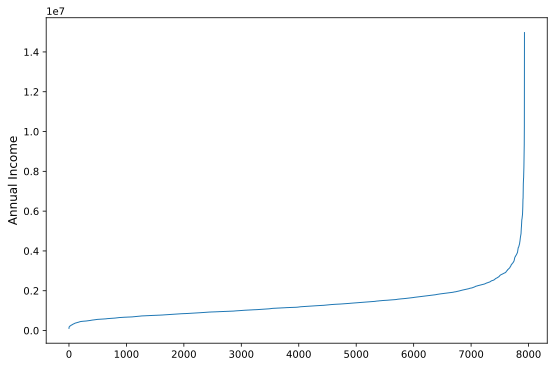

In [509]:
income = df['Annual Income'].sort_values().values
plt.figure(figsize = (9, 6))
plt.plot(income, linewidth=1)
plt.ylabel('Annual Income', size=12)

In [510]:
# income = df_train['Annual Income']

# df_train = df_train[income.isnull() |
#                    (income < income.quantile(.99)) & 
#                    (income > income.quantile(.01))            

* `Purpose` - значения vacation (8) и renewable energy (2) - выбросы, 2 заменим на самое популярное, а 8 заменим на Take a trip (это одно и то же)

In [511]:
purpose = df['Purpose']

df['Purpose'].loc[purpose.isin(['renewable energy', 'educational expenses', 
                                    'wedding', 'moving', 'major purchase'])] = 'other'
df['Purpose'].loc[purpose == 'vacation'] = 'take a trip'        
df['Purpose'].loc[purpose == 'small business'] = 'business loan'
df['Purpose'].loc[purpose == 'buy house'] = 'home improvements'

* `Tax Liens` -  значения по большей части - нули. Можно попробовать все ненулевые сделать 1

In [512]:
df['Tax Liens'].loc[df['Tax Liens'] != 0] = 1

* `Maximum Open Credit` - есть нулевые значения, они противоречат значениям текущей задолженности. Они должны быть не меньше текущего долга

In [513]:
df[df['Maximum Open Credit'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0.0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0.0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,0.0,0.0,business loan,Short Term,218042.0,0.0,5855.0,738.0,0.0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,0.0,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0.0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,other,Long Term,338096.0,0.0,395.0,659.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Rent,394725.0,3 years,0.0,3.0,10.0,0.0,0.0,0.0,0.0,other,Long Term,52734.0,0.0,3434.0,692.0,NaN
1934,Home Mortgage,1946170.0,10+ years,0.0,11.0,21.7,0.0,0.0,22.0,0.0,home improvements,Short Term,563376.0,0.0,20435.0,747.0,NaN
2189,Home Mortgage,NaN,2 years,0.0,8.0,11.7,0.0,0.0,26.0,0.0,home improvements,Short Term,449856.0,0.0,31062.0,NaN,NaN
2199,Rent,1432847.0,< 1 year,0.0,6.0,14.9,0.0,0.0,13.0,0.0,other,Long Term,464552.0,0.0,11439.0,718.0,NaN


In [514]:
for i in range(0, len(df['Maximum Open Credit'].values)):
    if df['Maximum Open Credit'].values[i] == 0:
        df['Maximum Open Credit'].values[i] = df['Current Loan Amount'].values[i]

### Обработка категориальных признаков

In [515]:
df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [516]:
for cat_colname in df.select_dtypes(include='object'):
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

In [517]:
df['Years in current job_less 1 year'] = df['Years in current job_< 1 year']

df = df.drop('Years in current job_< 1 year', axis=1)

In [518]:
df['Years in current job'] = df['Years in current job'].map({'< 1 year':'0', 
                                                             '1 year':'1', 
                                                             '2 years':'2', 
                                                             '3 years':'3', 
                                                             '4 years':'4', 
                                                             '5 years': '5', 
                                                             '6 years': '6', 
                                                             '7 years': '7', 
                                                             '8 years':'8', 
                                                             '9 years': '9', 
                                                             '10+ years': '10'}).astype(int)

In [519]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Purpose_business loan,Purpose_buy a car,Purpose_debt consolidation,Purpose_home improvements,Purpose_medical bills,Purpose_other,Purpose_take a trip,Years in current job_less 1 year
0,Own Home,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,1,99999999.0,47386.0,7914.0,749.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,0,264968.0,394972.0,18373.0,737.0,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,1,99999999.0,308389.0,13651.0,742.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,1,121396.0,95855.0,11338.0,694.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,1,125840.0,93309.0,7180.0,719.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


### Заполнение нулей для Credit Score и Annual income

* `Annual income` - построим предсказательную модель для заполнения нулей 

In [521]:
#  добавим биннарный признак для пропущенных значений
df['Nan Annual Income'] = 0
df['Nan Annual Income'].loc[df['Annual Income'].isnull()] = 1

In [522]:
features_AI = ['Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
               'Maximum Open Credit', 'Number of Credit Problems',
               'Months since last delinquent', 'Term', 'Years in current job',
               'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
               'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent']
target_AI = 'Annual Income'

X_train_AI = df[features_AI].loc[df['Annual Income'].notnull()]
Y_train_AI = df[target_AI].loc[df['Annual Income'].notnull()]
X_test_AI = df[features_AI].loc[df['Annual Income'].isnull()]

#X_train, X_test, y_train, y_test = train_test_split(X_train_AI, Y_train_AI, shuffle=True, test_size=0.25, random_state=211)
catb_for_AI = CatBoostRegressor(n_estimators=400, max_depth=6, learning_rate=0.03, eval_metric='R2', silent=True, random_state=21)
catb_for_AI.fit(X_train_AI, Y_train_AI)

Y_test_AI = catb_for_AI.predict(X_test_AI)

In [523]:
df.reset_index(inplace=True)
j = 0
for i in range(0, len(df['Annual Income'].values)): 
    if df['Annual Income'].isnull().values[i]:
        df['Annual Income'][i] = Y_test_AI[j]
        j += 1

In [ ]:
# модель gradient boosting
'''
gb_for_AI = GradientBoostingRegressor(random_state=21)
gb_for_AI.fit(X_train, y_train)
y_train_pred = gb_for_AI.predict(X_train)
y_test_pred = gb_for_AI.predict(X_test)

evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)
'''
# подбор параметров для него
'''
params = {
    'n_estimators' : [50, 100, 200, 300, 400],
    'max_depth' : [3, 5, 7, 9, 10, 12]
}

gs = GridSearchCV(gb_for_AI, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, 
                                                            shuffle=True), n_jobs=-1)
gs.fit(X_train, y_train)

gs.best_params_
'''
# важность признаков
'''
feature_importances = pd.DataFrame(zip(X_train.columns, gb_for_AI.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)
'''

In [ ]:
len(X_train_AI.columns.tolist())

In [ ]:
# модель CatBoost
'''
catb_for_AI = CatBoostRegressor(n_estimators=400, max_depth=6, learning_rate=0.03, eval_metric='R2', silent=True, random_state=21)
catb_for_AI.fit(X_train, y_train)

y_train_pred = catb_for_AI.predict(X_train)
y_test_pred = catb_for_AI.predict(X_test)

evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)
'''
# подбор параметров для него (35 min)
'''
%%time
params = {
    'n_estimators':[50, 100, 200, 300, 400, 500], 
    'max_depth':[3, 5, 7, 9, 10, 11],
    'learning_rate':[0.001, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1]
}
gs_AI = GridSearchCV(catb_for_AI, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs_AI.fit(X_train, y_train)
gs_AI.best_params_
'''
# важность признаков
'''
feature_importances = pd.DataFrame(zip(X_train.columns, catb_for_AI.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)
'''

* `Credit Score` - построим предсказательную модель для заполнения нулей

In [524]:
df = df.drop('index', axis=1)
df.columns.values.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_medical bills',
 'Purpose_other',
 'Purpose_take a trip',
 'Years in current job_less 1 year',
 'Nan Ann

In [525]:
#  добавим биннарный признак для пропущенных значений
df['Nan Credit Score'] = 0
df['Nan Credit Score'].loc[df['Credit Score'].isnull()] = 1

In [526]:
target_CS = 'Credit Score'
features_CS = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
               'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
               'Months since last delinquent', 'Bankruptcies', 'Term', 'Current Loan Amount',
               'Current Credit Balance', 'Monthly Debt',  'Home Ownership_Home Mortgage',
               'Home Ownership_Own Home', 'Home Ownership_Rent',
               'Purpose_business loan', 'Purpose_buy a car', 'Purpose_debt consolidation',
               'Purpose_home improvements', 'Purpose_medical bills', 'Purpose_other',
               'Purpose_take a trip', 'Years in current job_less 1 year']

X_train_CS = df[features_CS].loc[df['Credit Score'].notnull()]
Y_train_CS = df[target_CS].loc[df['Credit Score'].notnull()]
X_test_CS = df[features_CS].loc[df['Credit Score'].isnull()]

# X_train, X_test, y_train, y_test = train_test_split(X_train_CS, Y_train_CS, shuffle=True, test_size=0.3, random_state=21)

In [527]:
catb_for_CS = CatBoostRegressor(eval_metric='R2', silent=True, random_state=21)
catb_for_CS.fit(X_train_CS, Y_train_CS)

Y_test_CS = catb_for_CS.predict(X_test_CS)

In [ ]:
# feature_importances = pd.DataFrame(zip(X_train_CS.columns, catb_for_CS.feature_importances_), 
#                                    columns=['feature_name', 'importance'])
# feature_importances.sort_values(by='importance', ascending=False)

In [ ]:
# #'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 200

# %%time
# params = {
#     'n_estimators':[200, 300, 400], 
#     'max_depth':[4, 5, 6, 7],
#     'learning_rate':[0.003, 0.005, 0.03, 0.05]
# }
# gs_CS = GridSearchCV(catb_for_CS, params, scoring='accuracy', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
# gs_CS.fit(X_train_CS, Y_train_CS)
# gs_CS.best_params_

In [528]:
df.reset_index(inplace=True)
j = 0
for i in range(0, len(df['Credit Score'].values)): 
    if df['Credit Score'].isnull().values[i]:
        df['Credit Score'][i] = Y_test_CS[j]
        j += 1

In [ ]:
# median = df_train['Credit Score'].median()
# df['Credit Score'].fillna(median, inplace=True) 

In [529]:
df.loc[df['Credit Score'].isnull()]

,index,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Purpose_business loan,Purpose_buy a car,Purpose_debt consolidation,Purpose_home improvements,Purpose_medical bills,Purpose_other,Purpose_take a trip,Years in current job_less 1 year,Nan Annual Income,Nan Credit Score


### Построение новых признаков

In [530]:
df['Class Credit Score'] = 0
df['Class Credit Score'].loc[df['Credit Score'] < 600] = 1
df['Class Credit Score'].loc[(df['Credit Score'] >= 600) & (df['Credit Score'] < 650)] = 2
df['Class Credit Score'].loc[(df['Credit Score'] >= 650) & (df['Credit Score'] < 700)] = 3
df['Class Credit Score'].loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 725)] = 4
df['Class Credit Score'].loc[(df['Credit Score'] >= 725) & (df['Credit Score'] < 735)] = 5
df['Class Credit Score'].loc[(df['Credit Score'] >= 735) & (df['Credit Score'] < 745)] = 6
df['Class Credit Score'].loc[(df['Credit Score'] >= 745) & (df['Credit Score'] < 755)] = 7
df['Class Credit Score'].loc[df['Credit Score'] >= 755] = 8
        
df['Class Credit Score'] = df['Class Credit Score'].astype(int)

In [531]:
df['Mounthly Income'] = df['Annual Income'] / 12

In [532]:
gp = df.groupby(['Years in current job'])['Annual Income'].mean()
df["Mean Income By Stage"] = df['Years in current job'].map(gp.to_dict())

In [533]:
gp = df.groupby(['Class Credit Score'])['Credit Score'].mean()
df["Mean Credit Score By Stage"] = df['Class Credit Score'].map(gp.to_dict())

In [534]:
gp = df.groupby(['Years in current job'])['Annual Income'].mean()
df["Mean Annual Income by Class Credit Score"] = df['Years in current job'].map(gp.to_dict())

In [535]:
# разница между зп и долгом
df['Mounthly Income and Debt Diff '] = df['Mounthly Income'] - df['Monthly Debt']

In [536]:
df['Is Credit Score too large'] = 0
df['Is Credit Score too large'].loc[df['Credit Score'] > 1000] = 1

### Выделение целевой переменной и групп признаков

In [590]:
df = df.drop('index', axis=1)
df_test = df.loc[df['Credit Default'].isnull()]
df_train = df.loc[df['Credit Default'].notnull()]

KeyError: "['index'] not found in axis"

In [591]:
df.columns.values.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_medical bills',
 'Purpose_other',
 'Purpose_take a trip',
 'Years in current job_less 1 year',
 'Nan Ann

In [600]:
TARGET = 'Credit Default'
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                      'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                      'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance', 
                      'Monthly Debt', 'Credit Score']

NEW_FEATURE_NAMES = ['Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent',
                     'Purpose_business loan', 'Purpose_buy a car', 'Purpose_debt consolidation', 
                     'Purpose_home improvements', 'Purpose_medical bills', 'Purpose_other',
                     'Purpose_take a trip', 'Years in current job_1 year', 'Years in current job_less 1 year',
                     'Nan Annual Income', 'Nan Credit Score', 'Class Credit Score', 'Mounthly Income',
                     'Mean Income By Stage', 'Mean Credit Score By Stage', 'Mean Annual Income by Class Credit Score',
                     'Mounthly Income and Debt Diff ', 'Is Credit Score too large']

# NUMERIC_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Number of Open Accounts', 
#                          'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
#                          'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 
#                          'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Class Credit Score', 
#                          'Mounthly Income', 'Mean Income By Stage', 'Mean Credit Score By Stage', 
#                          'Mean Annual Income by Class Credit Score', 'Mounthly Income and Debt Diff ']


### Нормализация данных

In [601]:
# scaler = StandardScaler()

# df_norm_train = df_train.copy()
# df_norm_test = df_test.copy()
# df_norm_train[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm_train[NUMERIC_FEATURE_NAMES])
# df_norm_test[NUMERIC_FEATURE_NAMES] = scaler.transform(df_norm_test[NUMERIC_FEATURE_NAMES])

### Разбиение на train и test

In [602]:
X = df_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
y = df_train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)

### Балансировка целевой переменной

In [603]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
df_balanced[TARGET].value_counts()

0.0    4046
1.0    3158
Name: Credit Default, dtype: int64

In [604]:
X_train = df_balanced.drop(columns=TARGET)
y_train = df_balanced[TARGET]

### Построение и оценка базовых моделей

**CatBoost**

In [605]:
catb = CatBoostClassifier(learning_rate=0.009, max_depth=3, n_estimators=250, silent=True, random_state=21)
catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.68      0.86      0.76      4046
         1.0       0.73      0.47      0.57      3158

    accuracy                           0.69      7204
   macro avg       0.70      0.67      0.67      7204
weighted avg       0.70      0.69      0.68      7204

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83      1341
         1.0       0.59      0.49      0.53       534

    accuracy                           0.76      1875
   macro avg       0.70      0.67      0.68      1875
weighted avg       0.74      0.76      0.75      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1158  183
1.0              275  259


In [606]:
f1_score(y_test, y_test_pred, average=None)

array([0.83489546, 0.5307377 ])

In [607]:
feature_importances = pd.DataFrame(zip(X_train.columns, catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
12,Credit Score,31.280400
9,Current Loan Amount,31.044029
33,Is Credit Score too large,11.394641
25,Nan Annual Income,6.409690
26,Nan Credit Score,6.170209
27,Class Credit Score,4.060585
8,Term,3.991579
30,Mean Credit Score By Stage,2.493169
32,Mounthly Income and Debt Diff,1.530189
4,Maximum Open Credit,0.587865


### Перекрестная проверка

In [609]:
cv_score = cross_val_score(
    catb,
    X.fillna(-9999),
    y,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.40363636, 0.38361266, 0.34099617, 0.35047619, 0.33142857])

In [610]:
cv_score.mean(), cv_score.std()

(0.36202999141315456, 0.02723696328135879)

In [611]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.3347930281317958, 0.38926695469451333)

### Сделаем предсказания на тестовых данных

In [618]:
y_train_fin = df_train['Credit Default']

X_train_fin = df_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]

X_test_fin = df_test[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]

catb.fit(X_train_fin, y_train_fin)

y_test_fin = catb.predict(X_test_fin)

In [625]:
CreditDefault_pred = pd.DataFrame({'Id': np.arange(0,y_test_fin.shape[0]), 'Credit Default': y_test_fin})
CreditDefault_pred.to_csv('Sokolova_predictions.csv', index=False, encoding='utf-8', sep=',')
CreditDefault_pred.head(10)

,Id,Credit Default
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [620]:
CreditDefault_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              2500 non-null   int64  
 1   Credit Default  2500 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 39.2 KB


In [624]:
!pwd

/Users/Katrinka/Documents/Учеба/GeekBrains/Data Science/Classification project
